# Should the company increase the price to \\$ 59 from \\$39?

## Out line of the problem
- ### VP of the product want to increase the conversion rate.

- ### After how many days should they have stopped the test (to reach satistical significance)

## Notes of things to consider

- ### Will the effect differ based on the location (median income of the area), or the device (may be this correlate with how much money they have or how serious they want to buy this product)?

- ### Will the effect differ based on how they were refereed to the site? Actively seeking? Refered by fried? May be they were told of the different price?

- ### Will the effect change with time? May be people started noticing higher price and then decide to buy when they found out that it was still offered at a cheaper price?

- ### Calculate the effect size? If the price increase by \\$20, then may be we don't need to sell as much?

- ### Are there repeating customers?

## Approach
- ### Yammer charges license fees to companies that uses the product. Yammer should care if the number of company that use the product changes or not. Check all metrics for how many companies performed the action.

## Summary
- ### E-mail related category saw a drop in engagement, but search related activity didn't drop as much.

- ### Within E-mail related activity, number of companies that was sending weekly digest and the number of companies whose employees opened the weekly digest was steadly increasing.

- ### Number of users who clicked the link in the E-mail dropped (but was recovering)

- ### Number of companies with new employees signing up was still increasing.

- ### There may have been changes in the way the user interact with the software, but overall number of companies using the software seems to be growing.

## Relevant analyses

In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Read in the data: two tables.

In [2]:
#Read the test_results.csv
current_path = os.getcwd()
file = '/datasets/Cost/test_results.csv'
test_results = pd.read_csv(current_path + file)

test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [3]:
#Read in the user data
file = '/datasets/Cost/user_table.csv'
user = pd.read_csv(current_path + file)

user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
#Check the unique values for the user id.
test_results.describe()

,user_id,test,price,converted
count,316800.000000,316800.000000,316800.000000,316800.000000
mean,499281.341840,0.360079,46.205051,0.018333
std,288591.154044,0.480024,9.601487,0.134154
min,3.000000,0.000000,39.000000,0.000000
25%,249525.750000,0.000000,39.000000,0.000000
50%,499021.500000,0.000000,39.000000,0.000000
75%,749025.500000,1.000000,59.000000,0.000000
max,1000000.000000,1.000000,59.000000,1.000000


In [6]:
#Check the summary of the user data.
user.describe()


,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


In [7]:
user.city.unique()

array(['Peabody', 'Reno', 'Rialto', 'Carson City', 'Chicago', 'New York',
       'Durham', 'Burke', 'Oklahoma City', 'Charlotte', 'Chesapeake',
       'Brentwood', 'Seattle', 'Oakland', 'Stratford', 'Topeka',
       'Fort Lauderdale', 'Newport News', 'Kansas City', 'Amarillo',
       'Lawton', 'Houston', 'Casas Adobes', 'Bridgeport', 'Birmingham',
       'Memphis', 'Quincy', 'Los Angeles', 'Federal Way',
       'Rancho Cucamonga', 'Fontana', 'Cuyahoga Falls', 'Gilbert',
       'Redford', 'Shreveport', 'Indianapolis', 'Austin', 'Hesperia',
       'Meriden', 'Toms River', 'Chicopee', 'Spring Hill', 'Dearborn',
       'Jacksonville', 'Avondale', 'La Habra', 'Toledo', 'Temple',
       'Colton', 'San Antonio', 'Eau Claire', 'Union City',
       'Redondo Beach', 'Mesa', 'Overland Park', 'Revere', 'Wellington',
       'Citrus Heights', 'Fort Smith', 'Yonkers', 'Cary', 'Fullerton',
       'Woonsocket', 'Southfield', 'Nashville', 'North Fort Myers',
       'Metairie', 'Florissant', 'Germantown'

In [16]:
user_city = user['city']
user_city_counts = user_city.value_counts()
user_city_counts[0:20]

New York          25748
Chicago            7153
Houston            6706
San Antonio        4633
Los Angeles        4141
San Jose           3354
Indianapolis       3217
Jacksonville       2905
Philadelphia       2541
Las Vegas          2426
Austin             2292
Seattle            2204
Oklahoma City      1796
Charlotte          1768
Tucson             1732
Virginia Beach     1712
Oakland            1686
Nashville          1581
Mesa               1557
Memphis            1540
Name: city, dtype: int64

In [18]:
user_city_counts_normalized = user_city.value_counts(normalize=True)
user_city_counts_normalized[0:50]

New York          0.093420
Chicago           0.025953
Houston           0.024331
San Antonio       0.016810
Los Angeles       0.015025
San Jose          0.012169
Indianapolis      0.011672
Jacksonville      0.010540
Philadelphia      0.009219
Las Vegas         0.008802
Austin            0.008316
Seattle           0.007997
Oklahoma City     0.006516
Charlotte         0.006415
Tucson            0.006284
Virginia Beach    0.006212
Oakland           0.006117
Nashville         0.005736
Mesa              0.005649
Memphis           0.005587
Minneapolis       0.005319
Fort Worth        0.005185
Buffalo           0.004728
Raleigh           0.004691
New Orleans       0.004582
Springfield       0.004521
Tampa             0.004416
Dallas            0.004379
Detroit           0.004274
Plano             0.003915
Riverside         0.003686
Columbus          0.003665
Richmond          0.003617
Rochester         0.003606
Milwaukee         0.003519
Louisville        0.003363
Saint Louis       0.003309
T

In [10]:
#looks like there are no repeat customers.
test_user = test_results['user_id']
test_user_counts = test_user.value_counts()
test_user_counts

2047      1
338394    1
465846    1
407572    1
753429    1
         ..
291876    1
293925    1
857669    1
814119    1
2049      1
Name: user_id, Length: 316800, dtype: int64

### Merge dataframe so we can find where each user lives

In [14]:
test_results_user = pd.merge(test_results, user, on = 'user_id', how='left')

test_results_user.head(20)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,New York,USA,40.67,-73.94
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47


### For very minimal analysis, group by test and find if the coversion rate is significantly different.

In [39]:
test_control_group = test_results_user.groupby('test') 

In [40]:
test_group = test_control_group.get_group(1) 
control_group = test_control_group.get_group(0)

test_rate = sum(test_group['converted'])/test_group.shape[0]
test_rate

0.015542678810936857

In [41]:
control_rate = sum(control_group['converted'])/control_group.shape[0]
control_rate

0.019903614220108817

In [42]:
59/39 * test_rate

0.023513283329366013

In [55]:
# we need to bootstrap to find the confidence interval
control_converted=control_group['converted']
control_rate_boot = np.zeros((1000,1))

for boot_sample in range (1000):
    sample_set = control_converted.sample(frac=1, replace=True)
    control_rate_boot[boot_sample]=sum(sample_set)/sample_set.shape[0]


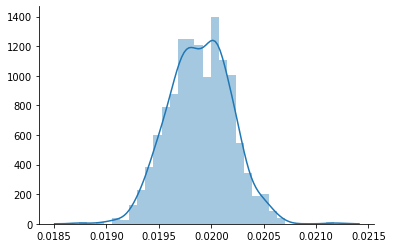

In [56]:
sb.distplot(control_rate_boot)
sb.despine()

In [57]:
# we need to bootstrap to find the confidence interval
test_converted=test_group['converted']
test_rate_boot = np.zeros((1000,1))

for boot_sample in range (1000):
    sample_set = test_converted.sample(frac=1, replace=True)
    test_rate_boot[boot_sample]=sum(sample_set)/sample_set.shape[0]


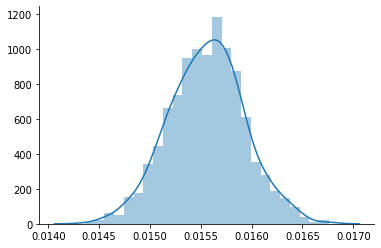

In [58]:
sb.distplot(test_rate_boot)
sb.despine()

In [ ]:
#actually if we want to check 

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

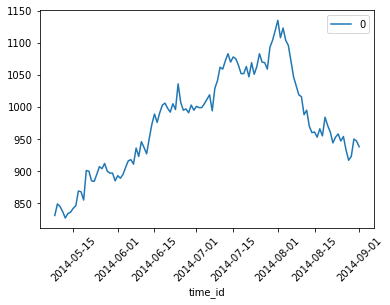

In [11]:
engagement_events=event_users.loc[event_users['event_type']=='engagement']

company_users = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_users_weekly=engagement_events[(engagement_events['occurred_at'] >= selected_period.iloc[rows,2]) & (engagement_events['occurred_at'] < selected_period.iloc[rows,3])]
    #signup_counts[rows,0]=selected_period.iloc[rows,1]
    #period_login=login_events_weekly.count()
    unique_company=company_users_weekly.company_id.unique()
    company_users[rows,0]=unique_company.shape[0]
    
company_u_dataframe = pd.DataFrame(data=company_users, index = selected_period.iloc[:,1])
sb.lineplot(data=company_u_dataframe)
plt.xticks(rotation = 45)

### Check individual activity and see if there is any one activity in particular that goes down.

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

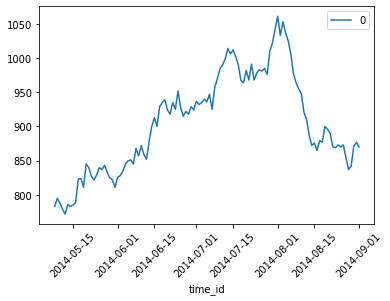

In [12]:
homepage_events=event_users.loc[event_users['event_name']=='home_page']

company_homepage = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_homepage_weekly=homepage_events[(homepage_events['occurred_at'] >= selected_period.iloc[rows,2]) & (homepage_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_homepage_weekly.company_id.unique()
    company_homepage[rows,0]=unique_company.shape[0]
    
homepage_u_dataframe = pd.DataFrame(data=company_homepage, index = selected_period.iloc[:,1])
sb.lineplot(data=homepage_u_dataframe)
plt.xticks(rotation = 45)

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

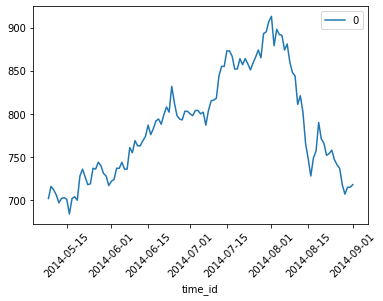

In [13]:
like_events=event_users.loc[event_users['event_name']=='like_message']

company_like = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_like_weekly=like_events[(like_events['occurred_at'] >= selected_period.iloc[rows,2]) & (like_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_like_weekly.company_id.unique()
    company_like[rows,0]=unique_company.shape[0]
    
like_u_dataframe = pd.DataFrame(data=company_like, index = selected_period.iloc[:,1])
sb.lineplot(data=like_u_dataframe)
plt.xticks(rotation = 45)

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

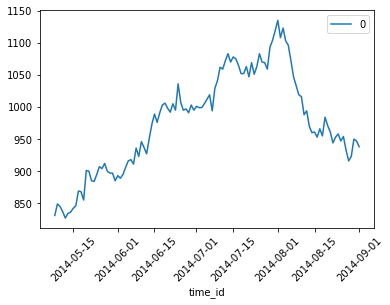

In [14]:
login_events=event_users.loc[event_users['event_name']=='login']

company_login = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_login_weekly=login_events[(login_events['occurred_at'] >= selected_period.iloc[rows,2]) & (login_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_login_weekly.company_id.unique()
    company_login[rows,0]=unique_company.shape[0]
    
login_u_dataframe = pd.DataFrame(data=company_login, index = selected_period.iloc[:,1])
sb.lineplot(data=login_u_dataframe)
plt.xticks(rotation = 45)

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

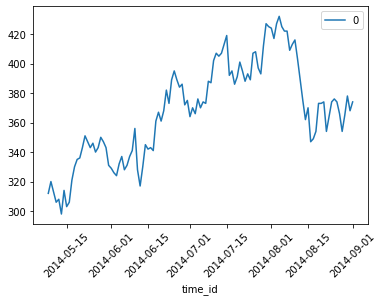

In [15]:
auto_events=event_users.loc[event_users['event_name']=='search_autocomplete']

company_auto = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_auto_weekly=auto_events[(auto_events['occurred_at'] >= selected_period.iloc[rows,2]) & (auto_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_auto_weekly.company_id.unique()
    company_auto[rows,0]=unique_company.shape[0]
    
auto_u_dataframe = pd.DataFrame(data=company_auto, index = selected_period.iloc[:,1])
sb.lineplot(data=auto_u_dataframe)
plt.xticks(rotation = 45)

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

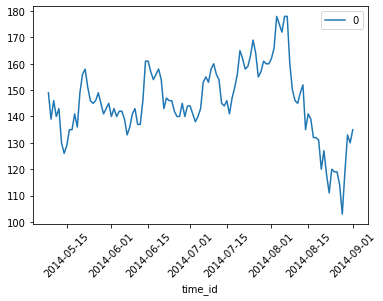

In [16]:
run_events=event_users.loc[event_users['event_name']=='search_run']

company_run = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_run_weekly=run_events[(run_events['occurred_at'] >= selected_period.iloc[rows,2]) & (run_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_run_weekly.company_id.unique()
    company_run[rows,0]=unique_company.shape[0]
    
run_u_dataframe = pd.DataFrame(data=company_run, index = selected_period.iloc[:,1])
sb.lineplot(data=run_u_dataframe)
plt.xticks(rotation = 45)

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

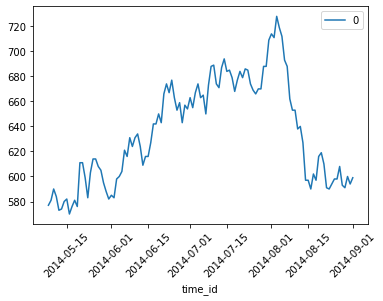

In [17]:
send_events=event_users.loc[event_users['event_name']=='send_message']

company_send = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_send_weekly=send_events[(send_events['occurred_at'] >= selected_period.iloc[rows,2]) & (send_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_send_weekly.company_id.unique()
    company_send[rows,0]=unique_company.shape[0]
    
send_u_dataframe = pd.DataFrame(data=company_send, index = selected_period.iloc[:,1])
sb.lineplot(data=send_u_dataframe)
plt.xticks(rotation = 45)

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

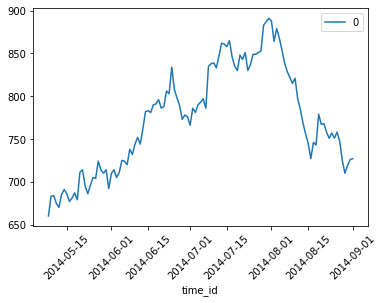

In [18]:
view_events=event_users.loc[event_users['event_name']=='view_inbox']

company_view = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_view_weekly=view_events[(view_events['occurred_at'] >= selected_period.iloc[rows,2]) & (view_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_view_weekly.company_id.unique()
    company_view[rows,0]=unique_company.shape[0]
    
view_u_dataframe = pd.DataFrame(data=company_view, index = selected_period.iloc[:,1])
sb.lineplot(data=view_u_dataframe)
plt.xticks(rotation = 45)

### Events related to e-mails dropped the most. Events related to searches don't drop as much, or in the process of recovery. Check what type of e-mail events drop the most.

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

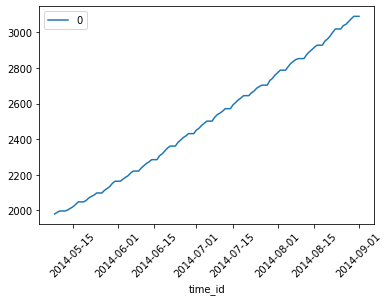

In [19]:
digest_events=email_users.loc[email_users['action']=='sent_weekly_digest']
company_digest = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_digest_weekly=digest_events[(digest_events['occurred_at'] >= selected_period.iloc[rows,2]) & (digest_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_digest_weekly.company_id.unique()
    company_digest[rows,0]=unique_company.shape[0]
    
digest_u_dataframe = pd.DataFrame(data=company_digest, index = selected_period.iloc[:,1])
sb.lineplot(data=digest_u_dataframe)
plt.xticks(rotation = 45)

### Number of company that is sending weekly digest is increasing linearly

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

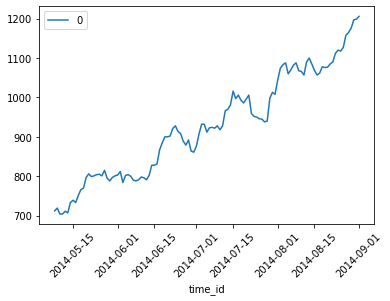

In [20]:
open_events=email_users.loc[email_users['action']=='email_open']
company_open = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_open_weekly=open_events[(open_events['occurred_at'] >= selected_period.iloc[rows,2]) & (open_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_open_weekly.company_id.unique()
    company_open[rows,0]=unique_company.shape[0]
    
open_u_dataframe = pd.DataFrame(data=company_open, index = selected_period.iloc[:,1])
sb.lineplot(data=open_u_dataframe)
plt.xticks(rotation = 45)

### Companies are opeing the E-mail that they received.

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

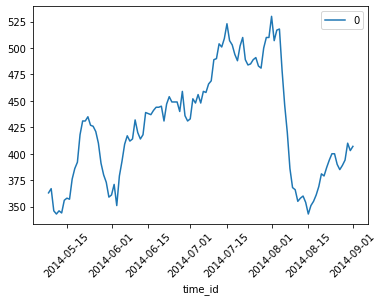

In [21]:
click_events=email_users.loc[email_users['action']=='email_clickthrough']
company_click = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_click_weekly=click_events[(click_events['occurred_at'] >= selected_period.iloc[rows,2]) & (click_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_click_weekly.company_id.unique()
    company_click[rows,0]=unique_company.shape[0]
    
click_u_dataframe = pd.DataFrame(data=company_click, index = selected_period.iloc[:,1])
sb.lineplot(data=click_u_dataframe)
plt.xticks(rotation = 45)

### Number of companies whose users have clicked at least once in a week decreased, but coming back up

(array([735368., 735385., 735399., 735415., 735429., 735446., 735460.,
        735477.]), <a list of 8 Text xticklabel objects>)

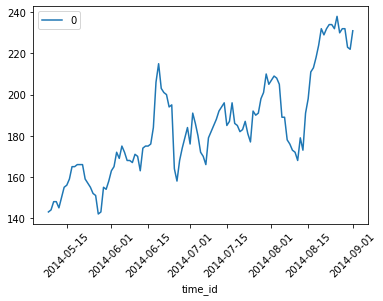

In [22]:
signup_events=event_users.loc[event_users['event_name']=='complete_signup']

company_signup = np.zeros((selected_period.shape[0],1))

#Go through the rolling time periods and count the signup events.
for rows in range (selected_period.shape[0]):
    #Select only the events during that period.
    company_signup_weekly=signup_events[(signup_events['occurred_at'] >= selected_period.iloc[rows,2]) & (signup_events['occurred_at'] < selected_period.iloc[rows,3])]
    unique_company=company_signup_weekly.company_id.unique()
    company_signup[rows,0]=unique_company.shape[0]
    
signup_u_dataframe = pd.DataFrame(data=company_signup, index = selected_period.iloc[:,1])
sb.lineplot(data=signup_u_dataframe)
plt.xticks(rotation = 45)

### Companies are still signing up users (after some dip)

## Results

- ### Some E-mail related actions have decreased but other actions remained to increase, suggesting that the way the users interact with the software may have changed.

- ### Check with the software developers to see if there were any new features added around beginning of August.

- ### If the drop in the E-mail related activity and login was an expected outcome from the change in the software, the company do not need to plan any response.

## Future directions

- ### Check if there were any differences in the activity based on the location or device.